# install the newest statsmodels

In [1]:
#! pip install statsmodels==0.12.1

# load all Python modules

In [2]:
%reset -f

import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sns
import numpy             as np
import statsmodels.api   as sm

from statsmodels.tsa.api       import VAR
from statsmodels.tsa.stattools import adfuller

# the usual settings we have been doing for several weeks

In [3]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
sns.mpl.rc('figure',figsize=(16, 6))

In [4]:
df = pd.read_csv('new_keynesian.csv')
df.index = pd.date_range(start='1960-01-01', periods=238, freq='Q')
df.drop(['quarter'], axis=1, inplace=True)

In [5]:
df = df.rename(columns={"inflation (% wrt same quarter last year)": "infl"})
df = df.rename(columns={"unemployment rate (%)": "unemp"})
df = df.rename(columns={"effective federal funds rate (%)": "intrate"})

In [6]:
df.head()

,infl,unemp,intrate
1960-03-31,1.39,5.13,3.93
1960-06-30,1.82,5.23,3.70
1960-09-30,1.36,5.53,2.94
1960-12-31,1.40,6.27,2.30
1961-03-31,1.51,6.80,2.00


In [7]:
df.tail()

,infl,unemp,intrate
2018-06-30,2.67,3.90,1.74
2018-09-30,2.63,3.80,1.92
2018-12-31,2.22,3.80,2.22
2019-03-31,1.63,3.87,2.40
2019-06-30,1.82,3.63,2.40


# check the time index of the data

In [8]:
df.index

DatetimeIndex(['1960-03-31', '1960-06-30', '1960-09-30', '1960-12-31',
               '1961-03-31', '1961-06-30', '1961-09-30', '1961-12-31',
               '1962-03-31', '1962-06-30',
               ...
               '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31',
               '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31',
               '2019-03-31', '2019-06-30'],
              dtype='datetime64[ns]', length=238, freq='Q-DEC')

# plot the original and differenced series
## if the series is stationery, the moving average and moving std should be hovering around some constant value

In [9]:
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()

df1['data'] = df['infl']
df2['data'] = df['unemp']
df3['data'] = df['intrate']

In [10]:
def plot_rolling(df,name):
    
    df['z_data'] = (df['data'] - df.data.rolling(window=4).mean()) / df.data.rolling(window=4).std()
    df['zp_data'] = df['z_data'] - df['z_data'].shift(1)
    df['zs_data'] = df['z_data'] - df['z_data'].shift(4)
    
    fig, ax = plt.subplots(4,figsize=(12, 9))
    ax[0].scatter(df.index, df.data, color='c', label=name)
    ax[0].plot(df.data.rolling(window=4).mean(), color='b', label="moving avergae");
    ax[0].plot(df.data.rolling(window=4).std(), color='r', label="moving std");
    ax[0].legend()

    ax[1].scatter(df.index, df.z_data, color='c', label="de-trended "+name)
    ax[1].plot(df.z_data.rolling(window=4).mean(), color='b', label="moving aveage");
    ax[1].plot(df.z_data.rolling(window=4).std(), color='r', label="moving std");
    ax[1].legend()

    ax[2].scatter(df.index, df.zp_data, color='c', label="1 lag differenced de-trended "+name)
    ax[2].plot(df.zp_data.rolling(window=4).mean(), color='b', label="moving average");
    ax[2].plot(df.zp_data.rolling(window=4).std(), color='r', label="moving std");
    ax[2].legend()
    
    ax[3].scatter(df.index, df.zs_data, color='c', label="seasonal differenced de-trended "+name)
    ax[3].plot(df.zs_data.rolling(window=4).mean(), color='b', label="moving average");
    ax[3].plot(df.zs_data.rolling(window=4).std(), color='r', label="moving std");
    ax[3].legend()

    plt.tight_layout()
    fig.autofmt_xdate()


## plot for "infl"

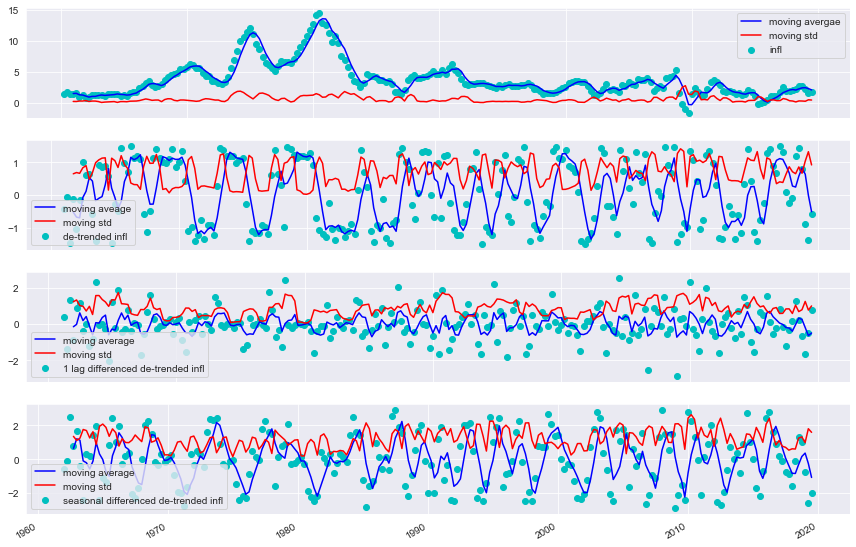

In [11]:
plot_rolling(df1,'infl')

## plot for "unemp"

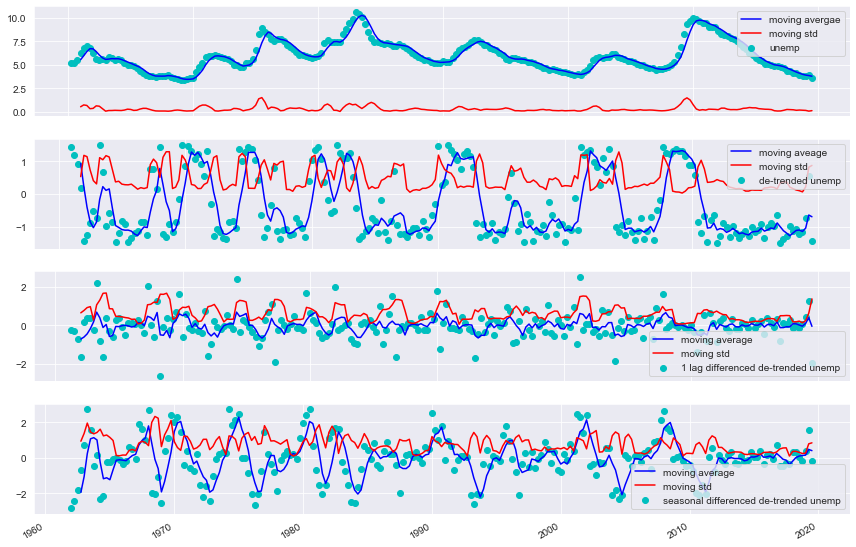

In [12]:
plot_rolling(df2, 'unemp')

## plot for "intrate"

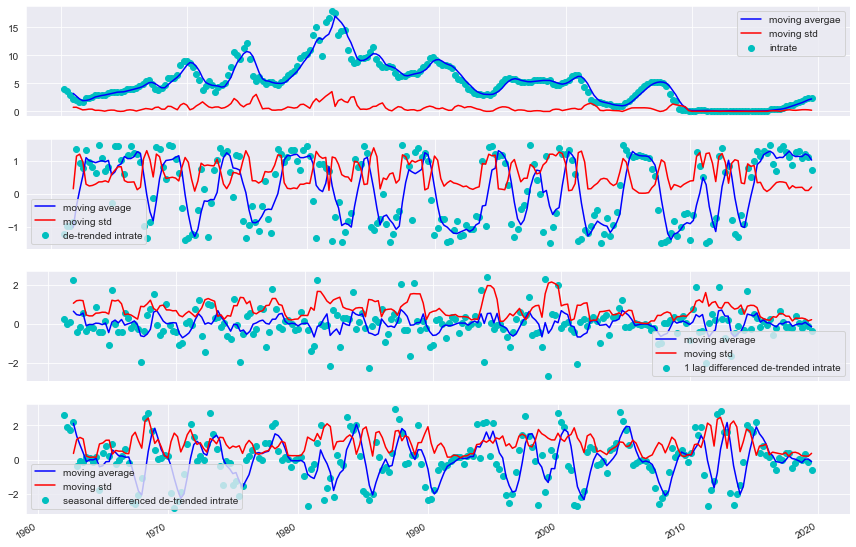

In [13]:
plot_rolling(df3, 'intrate')

# ADF test for each variable

In [14]:
def adf_test(df,name):
    
    print("-----------------------------------------")
    print("for variable " + name)
    print("-----------------------------------------")
    
    dftest = adfuller(df.data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
      print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

    print("\n > Is the de-trended data stationary ?")
    dftest = adfuller(df.z_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
      print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

    print("\n > Is the 1-lag differenced de-trended data stationary ?")
    dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
      print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
    print("\n > Is the seasonal differenced de-trended data stationary ?")
    dftest = adfuller(df.zs_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
      print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

## test for infl

In [15]:
adf_test(df1, 'infl')

-----------------------------------------
for variable infl
-----------------------------------------
Test statistic = -1.694
P-value = 0.434
Critical values :
	1%: -3.4597521044060353 - The data is not stationary with 99% confidence
	5%: -2.874472927517147 - The data is not stationary with 95% confidence
	10%: -2.5736628197530864 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -6.484
P-value = 0.000
Critical values :
	1%: -3.4594900381360034 - The data is  stationary with 99% confidence
	5%: -2.8743581895178485 - The data is  stationary with 95% confidence
	10%: -2.573601605503697 - The data is  stationary with 90% confidence

 > Is the 1-lag differenced de-trended data stationary ?
Test statistic = -7.664
P-value = 0.000
Critical values :
	1%: -3.4604283689894815 - The data is  stationary with 99% confidence
	5%: -2.874768966942149 - The data is  stationary with 95% confidence
	10%: -2.57382076446281 - The data is  stationary 

## test for unemp

In [16]:
adf_test(df2, 'unemp')

-----------------------------------------
for variable unemp
-----------------------------------------
Test statistic = -2.852
P-value = 0.051
Critical values :
	1%: -3.4593607492757554 - The data is not stationary with 99% confidence
	5%: -2.8743015807562924 - The data is not stationary with 95% confidence
	10%: -2.5735714042782396 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -5.785
P-value = 0.000
Critical values :
	1%: -3.4586084859607156 - The data is  stationary with 99% confidence
	5%: -2.873972159235721 - The data is  stationary with 95% confidence
	10%: -2.57339565928848 - The data is  stationary with 90% confidence

 > Is the 1-lag differenced de-trended data stationary ?
Test statistic = -17.259
P-value = 0.000
Critical values :
	1%: -3.458731141928624 - The data is  stationary with 99% confidence
	5%: -2.8740258764297293 - The data is  stationary with 95% confidence
	10%: -2.5734243167124093 - The data is  stationary 

## test for intrate

In [17]:
adf_test(df3, 'intrate')

-----------------------------------------
for variable intrate
-----------------------------------------
Test statistic = -1.965
P-value = 0.302
Critical values :
	1%: -3.459105583381277 - The data is not stationary with 99% confidence
	5%: -2.8741898504150574 - The data is not stationary with 95% confidence
	10%: -2.5735117958412097 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -6.453
P-value = 0.000
Critical values :
	1%: -3.4586084859607156 - The data is  stationary with 99% confidence
	5%: -2.873972159235721 - The data is  stationary with 95% confidence
	10%: -2.57339565928848 - The data is  stationary with 90% confidence

 > Is the 1-lag differenced de-trended data stationary ?
Test statistic = -7.405
P-value = 0.000
Critical values :
	1%: -3.460018927623594 - The data is  stationary with 99% confidence
	5%: -2.8745897386146817 - The data is  stationary with 95% confidence
	10%: -2.57372514086348 - The data is  stationary

# it seems that seasonal difference is enough, let's diff the data

In [18]:
df = df.diff(4)
df = df.dropna()
df.head()

,infl,unemp,intrate
1961-03-31,0.12,1.67,-1.93
1961-06-30,-0.95,1.77,-1.97
1961-09-30,-0.15,1.24,-1.26
1961-12-31,-0.69,-0.07,0.10
1962-03-31,-0.62,-1.17,0.46


In [19]:
df = df.rename(columns={"infl"   : "S4_infl"})
df = df.rename(columns={"unemp"  : "S4_unemp"})
df = df.rename(columns={"intrate": "S4_intrate"})

# I am collecting all tasks into one function "var_est", which includes
* **VAR estimation**
* **input time series plot**
* **ACF of the input time series**
* **IRF**
* **cumulative effect**
* **Granger test (I LOATHE THE NAME "CAUSALITY")**
* **Ljung-Box test**

In [20]:
def var_est(df,i):
    
    print("---------------------------------------------")
    print("VAR result for max lag = " + str(i))
    print("---------------------------------------------")
    
    model  = VAR(df)
    result = model.fit(i, trend='ctt')
    
    print(result.summary())
    
    print("---------------------------------------------")
    print("Plotting input time series")
    print("---------------------------------------------")
    
    result.plot()
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting time series autocorrelation function")
    print("---------------------------------------------")
          
    result.plot_acorr()
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting IRF")
    print("---------------------------------------------")
    
    irf = result.irf(10)
    irf.plot(orth=False)
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting cumulative effects")
    print("---------------------------------------------")
    
    irf.plot_cum_effects(orth=False)
    plt.show()
    
    print("---------------------------------------------")
    print("Granger test")
    print("---------------------------------------------")
    
    test_result1 = result.test_causality('S4_infl', ['S4_unemp', 'S4_intrate'], kind='f')
    print(test_result1.summary())
    
    test_result2 = result.test_causality('S4_unemp', ['S4_infl', 'S4_intrate'], kind='f')
    print(test_result2.summary())
    
    test_result3 = result.test_causality('S4_intrate', ['S4_infl', 'S4_unemp'], kind='f')
    print(test_result3.summary())
    
    print("---------------------------------------------")
    print("Ljung-Box test for VAR")
    print("---------------------------------------------")
    test_result4 = result.test_whiteness()
    print(test_result4.summary())
    
    

# now let's try different max lag terms, from 1 to 5

---------------------------------------------
VAR result for max lag = 1
---------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Nov, 2020
Time:                     02:03:58
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.48404
Nobs:                     233.000    HQIC:                  -1.64313
Log likelihood:          -769.888    FPE:                   0.173669
AIC:                     -1.75064    Det(Omega_mle):        0.160914
--------------------------------------------------------------------
Results for equation S4_infl
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.057648         0.209011            0.276           0.783
trend               

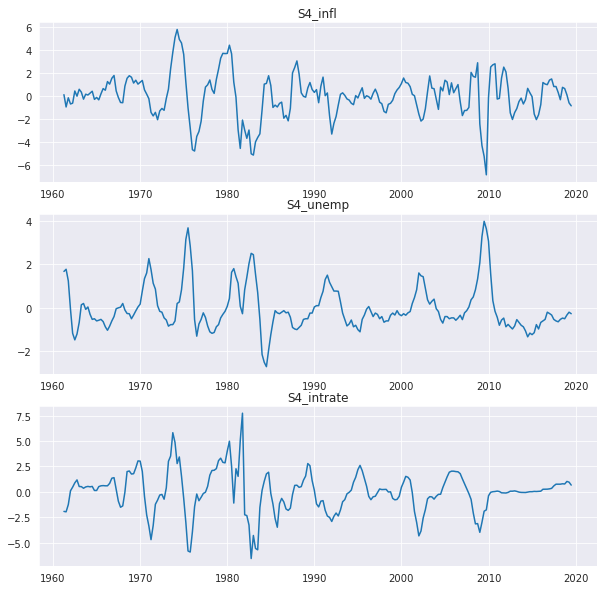

---------------------------------------------
Plotting time series autocorrelation function
---------------------------------------------


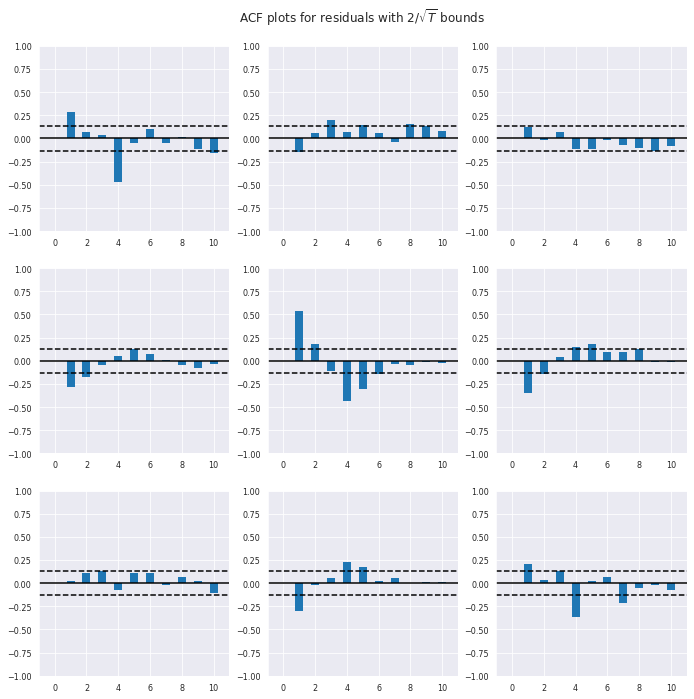

---------------------------------------------
Plotting IRF
---------------------------------------------


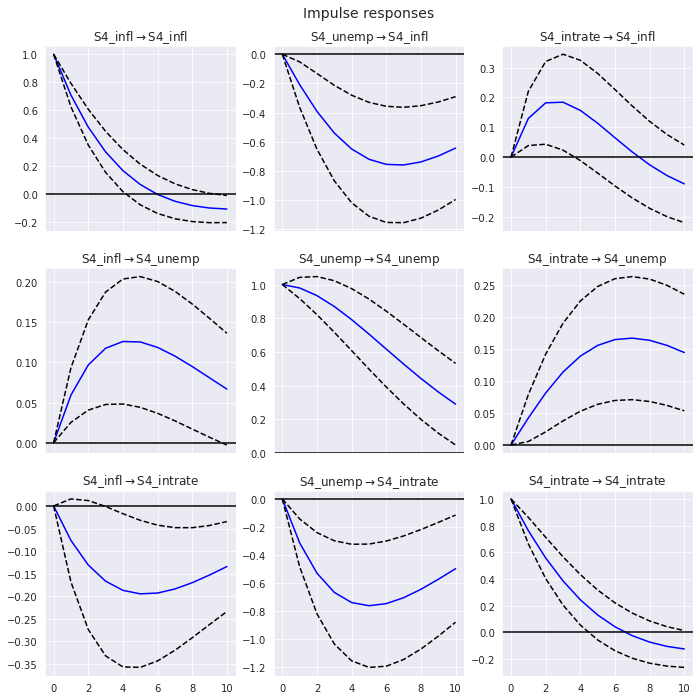

---------------------------------------------
Plotting cumulative effects
---------------------------------------------


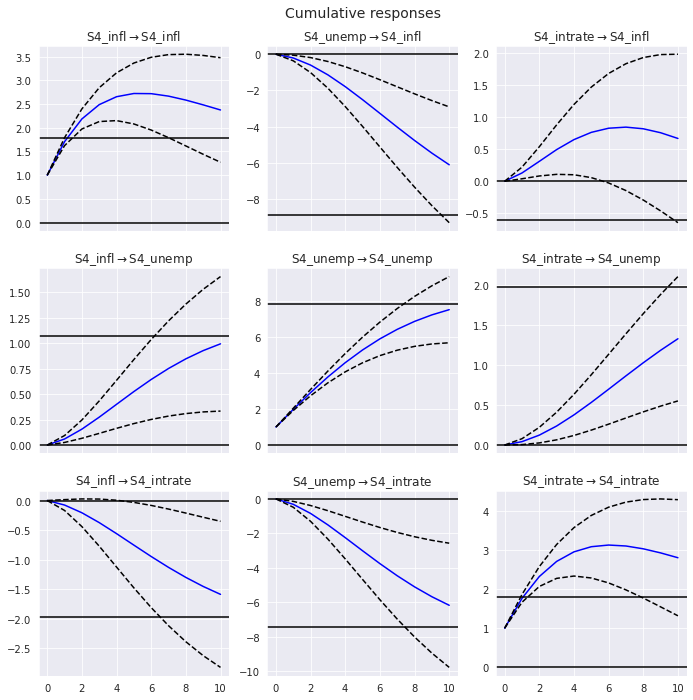

---------------------------------------------
Granger test
---------------------------------------------
Granger causality F-test. H_0: ['S4_unemp', 'S4_intrate'] do not Granger-cause S4_infl. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         14.78          3.009   0.000 (2, 681)
----------------------------------------------
Granger causality F-test. H_0: ['S4_infl', 'S4_intrate'] do not Granger-cause S4_unemp. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         15.45          3.009   0.000 (2, 681)
----------------------------------------------
Granger causality F-test. H_0: ['S4_infl', 'S4_unemp'] do not Granger-cause S4_intrate. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         7.785

In [21]:
var_est(df,1)

---------------------------------------------
VAR result for max lag = 2
---------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Nov, 2020
Time:                     02:04:00
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.97346
Nobs:                     232.000    HQIC:                  -2.21282
Log likelihood:          -685.129    FPE:                  0.0930634
AIC:                     -2.37459    Det(Omega_mle):       0.0830217
--------------------------------------------------------------------
Results for equation S4_infl
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.081817         0.201748            0.406           0.685
trend               

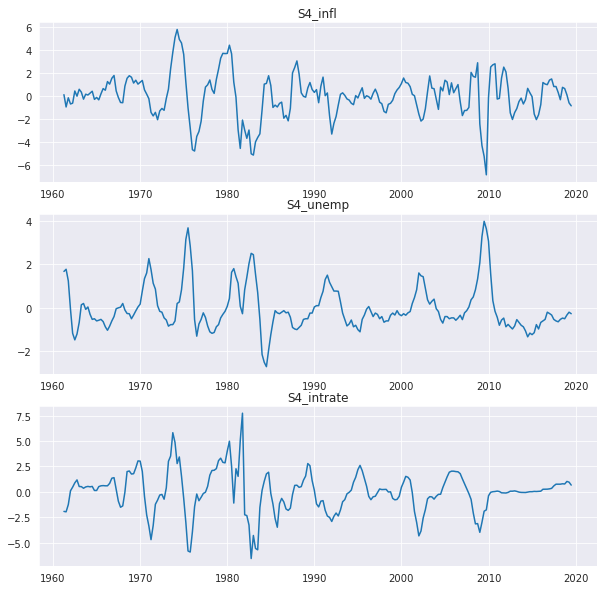

---------------------------------------------
Plotting time series autocorrelation function
---------------------------------------------


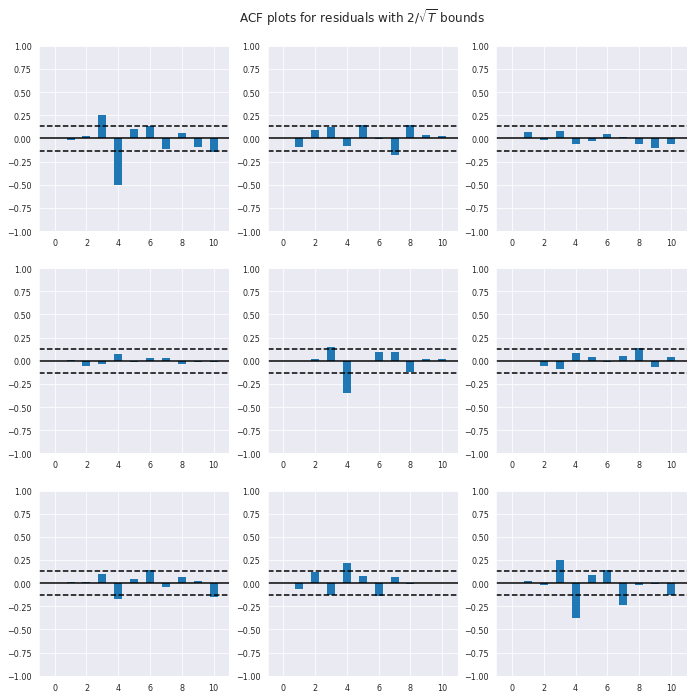

---------------------------------------------
Plotting IRF
---------------------------------------------


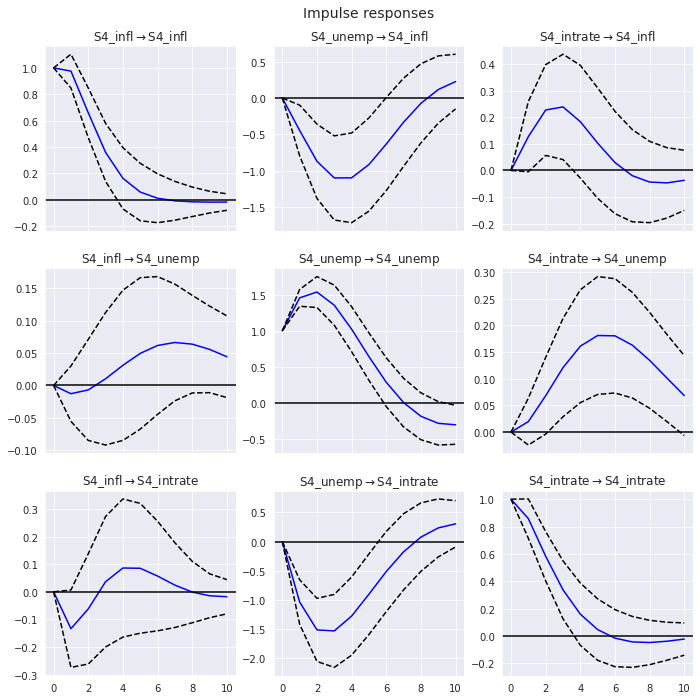

---------------------------------------------
Plotting cumulative effects
---------------------------------------------


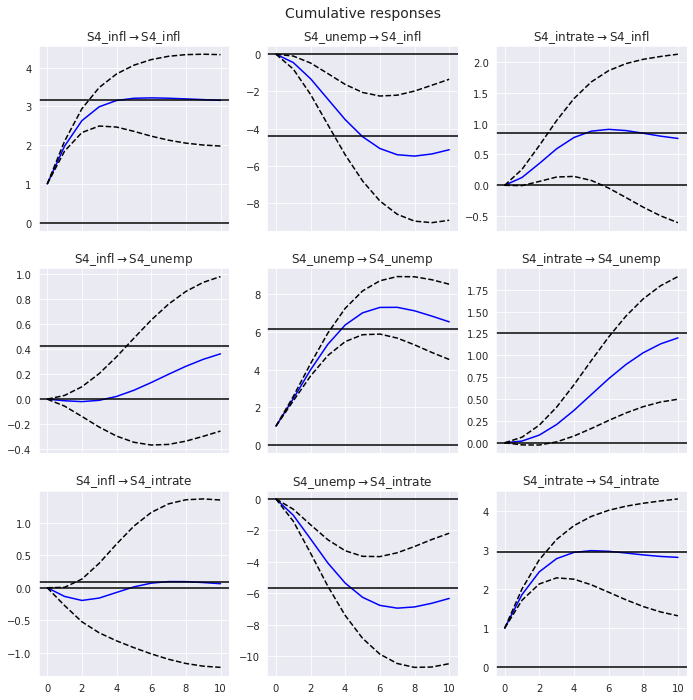

---------------------------------------------
Granger test
---------------------------------------------
Granger causality F-test. H_0: ['S4_unemp', 'S4_intrate'] do not Granger-cause S4_infl. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         6.802          2.385   0.000 (4, 669)
----------------------------------------------
Granger causality F-test. H_0: ['S4_infl', 'S4_intrate'] do not Granger-cause S4_unemp. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         3.632          2.385   0.006 (4, 669)
----------------------------------------------
Granger causality F-test. H_0: ['S4_infl', 'S4_unemp'] do not Granger-cause S4_intrate. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         8.226

In [22]:
var_est(df,2)

---------------------------------------------
VAR result for max lag = 3
---------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Nov, 2020
Time:                     02:04:03
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.82930
Nobs:                     231.000    HQIC:                  -2.14940
Log likelihood:          -674.077    FPE:                  0.0939024
AIC:                     -2.36578    Det(Omega_mle):       0.0806666
--------------------------------------------------------------------
Results for equation S4_infl
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.056644         0.201903            0.281           0.779
trend               

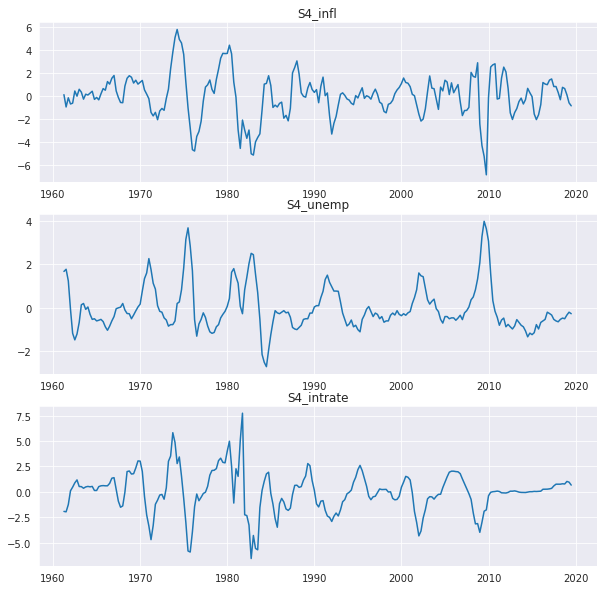

---------------------------------------------
Plotting time series autocorrelation function
---------------------------------------------


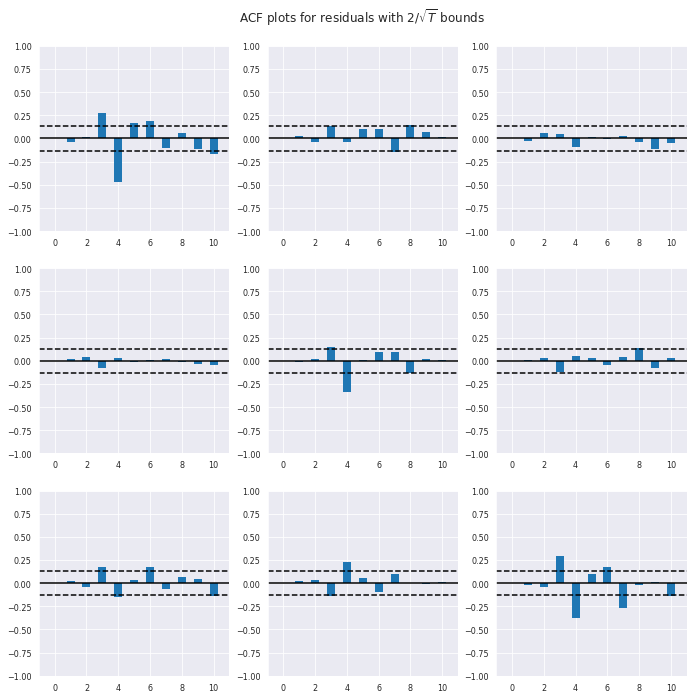

---------------------------------------------
Plotting IRF
---------------------------------------------


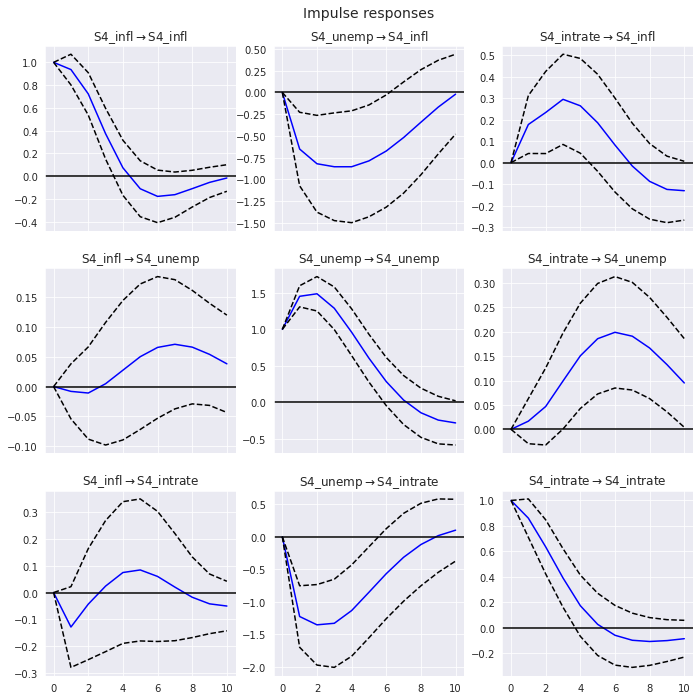

---------------------------------------------
Plotting cumulative effects
---------------------------------------------


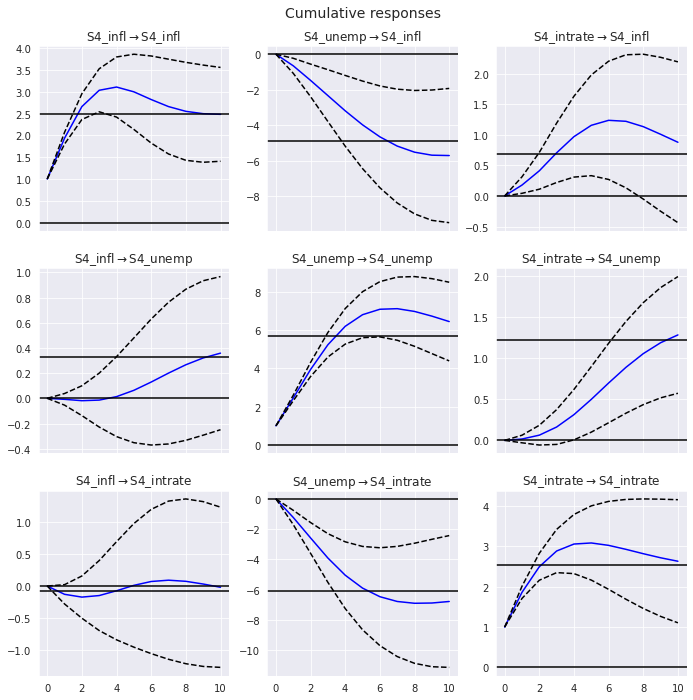

---------------------------------------------
Granger test
---------------------------------------------
Granger causality F-test. H_0: ['S4_unemp', 'S4_intrate'] do not Granger-cause S4_infl. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         6.048          2.112   0.000 (6, 657)
----------------------------------------------
Granger causality F-test. H_0: ['S4_infl', 'S4_intrate'] do not Granger-cause S4_unemp. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         2.642          2.112   0.015 (6, 657)
----------------------------------------------
Granger causality F-test. H_0: ['S4_infl', 'S4_unemp'] do not Granger-cause S4_intrate. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         5.664

In [23]:
var_est(df,3)

---------------------------------------------
VAR result for max lag = 3
---------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Nov, 2020
Time:                     02:04:05
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.82930
Nobs:                     231.000    HQIC:                  -2.14940
Log likelihood:          -674.077    FPE:                  0.0939024
AIC:                     -2.36578    Det(Omega_mle):       0.0806666
--------------------------------------------------------------------
Results for equation S4_infl
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.056644         0.201903            0.281           0.779
trend               

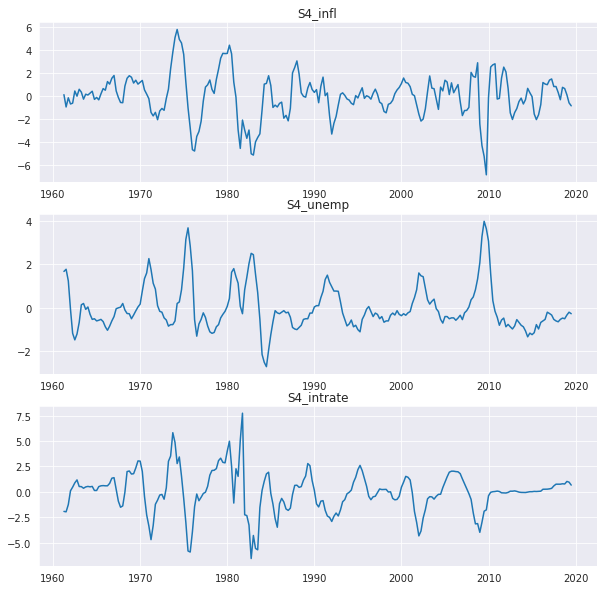

---------------------------------------------
Plotting time series autocorrelation function
---------------------------------------------


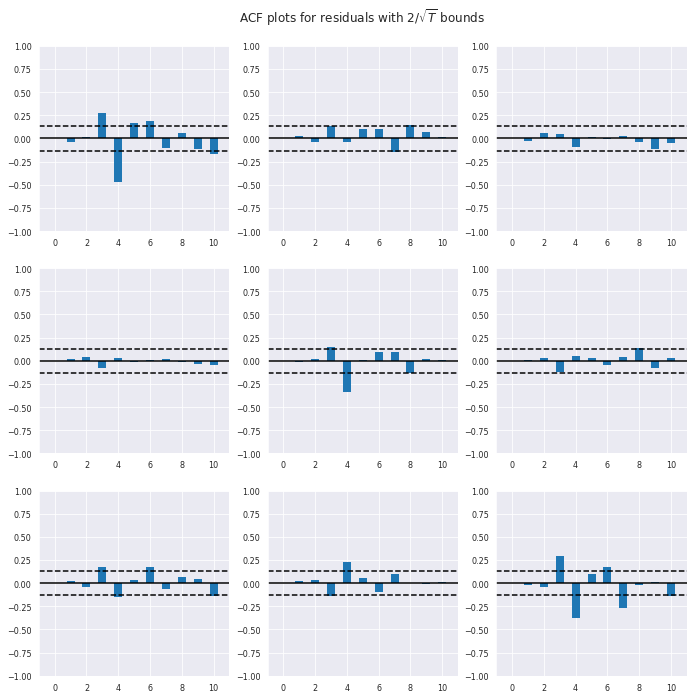

---------------------------------------------
Plotting IRF
---------------------------------------------


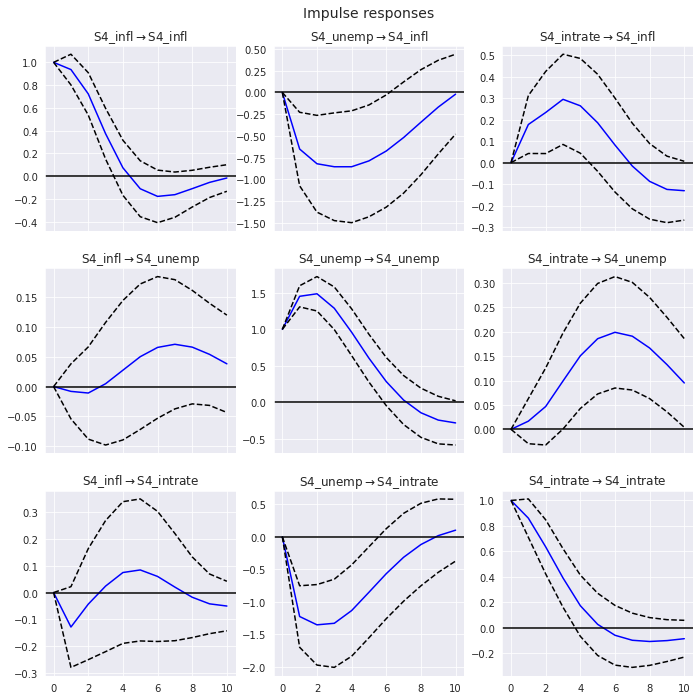

---------------------------------------------
Plotting cumulative effects
---------------------------------------------


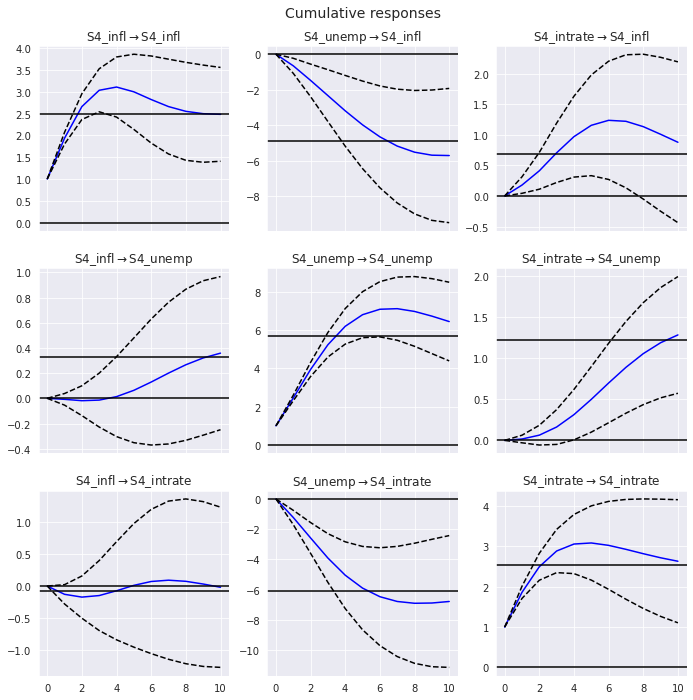

---------------------------------------------
Granger test
---------------------------------------------
Granger causality F-test. H_0: ['S4_unemp', 'S4_intrate'] do not Granger-cause S4_infl. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         6.048          2.112   0.000 (6, 657)
----------------------------------------------
Granger causality F-test. H_0: ['S4_infl', 'S4_intrate'] do not Granger-cause S4_unemp. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         2.642          2.112   0.015 (6, 657)
----------------------------------------------
Granger causality F-test. H_0: ['S4_infl', 'S4_unemp'] do not Granger-cause S4_intrate. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         5.664

In [24]:
var_est(df,3)

---------------------------------------------
VAR result for max lag = 4
---------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Nov, 2020
Time:                     02:04:08
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.84833
Nobs:                     230.000    HQIC:                  -2.24966
Log likelihood:          -644.153    FPE:                  0.0804242
AIC:                     -2.52100    Det(Omega_mle):       0.0665383
--------------------------------------------------------------------
Results for equation S4_infl
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.167776         0.195829            0.857           0.392
trend               

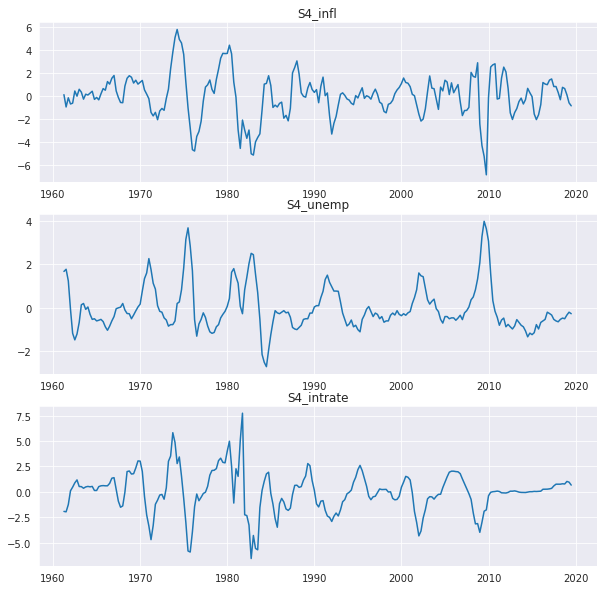

---------------------------------------------
Plotting time series autocorrelation function
---------------------------------------------


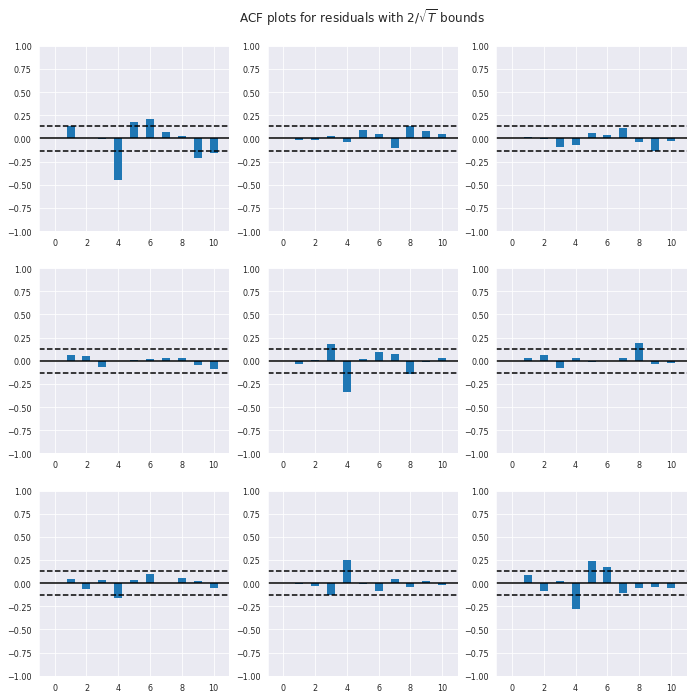

---------------------------------------------
Plotting IRF
---------------------------------------------


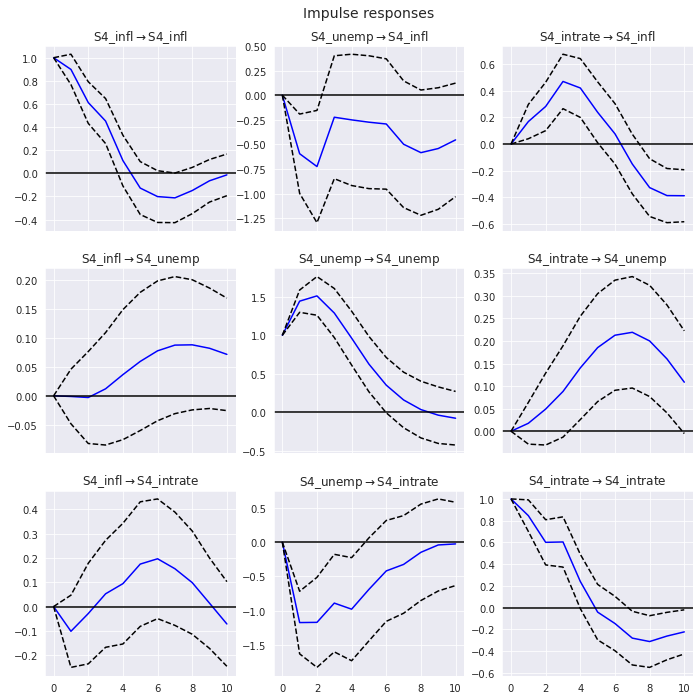

---------------------------------------------
Plotting cumulative effects
---------------------------------------------


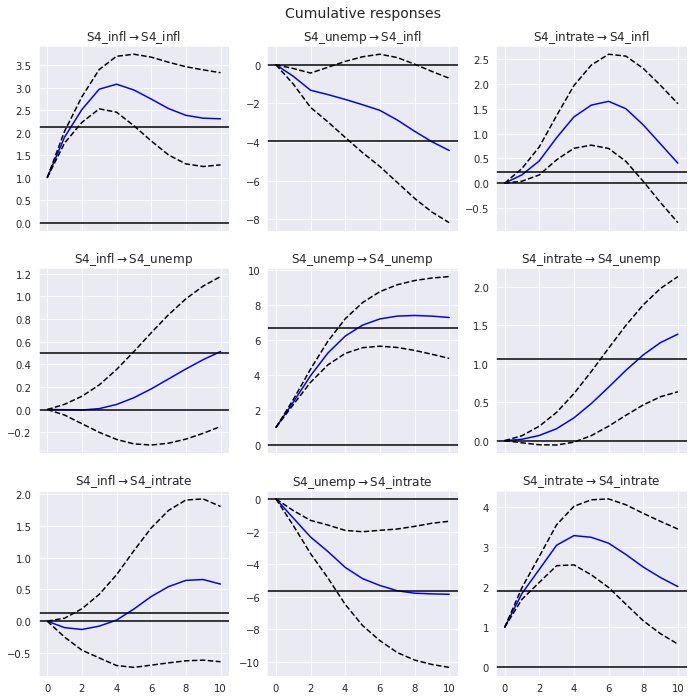

---------------------------------------------
Granger test
---------------------------------------------
Granger causality F-test. H_0: ['S4_unemp', 'S4_intrate'] do not Granger-cause S4_infl. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         6.688          1.953   0.000 (8, 645)
----------------------------------------------
Granger causality F-test. H_0: ['S4_infl', 'S4_intrate'] do not Granger-cause S4_unemp. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         2.084          1.953   0.035 (8, 645)
----------------------------------------------
Granger causality F-test. H_0: ['S4_infl', 'S4_unemp'] do not Granger-cause S4_intrate. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         4.375

In [25]:
var_est(df,4)

---------------------------------------------
VAR result for max lag = 5
---------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Nov, 2020
Time:                     02:04:10
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -2.13329
Nobs:                     229.000    HQIC:                  -2.61633
Log likelihood:          -583.839    FPE:                  0.0527595
AIC:                     -2.94299    Det(Omega_mle):       0.0420452
--------------------------------------------------------------------
Results for equation S4_infl
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.079509         0.180167            0.441           0.659
trend               

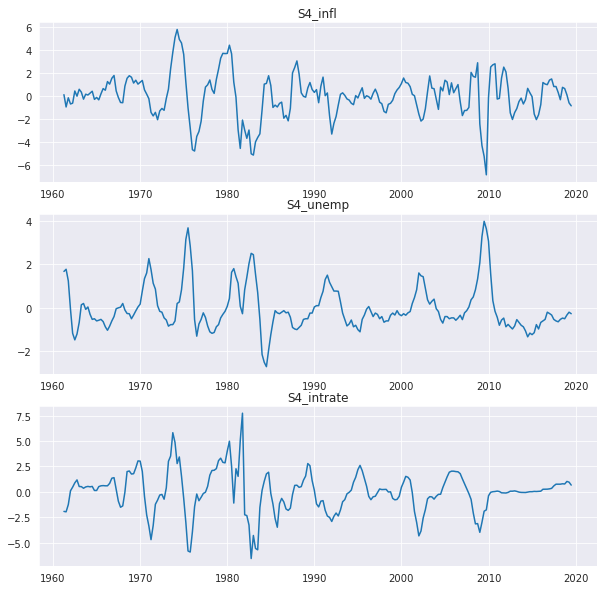

---------------------------------------------
Plotting time series autocorrelation function
---------------------------------------------


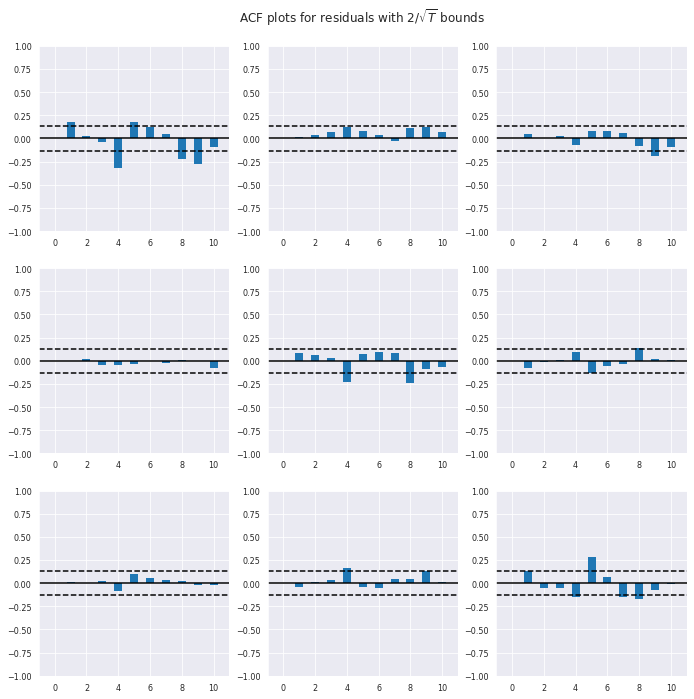

---------------------------------------------
Plotting IRF
---------------------------------------------


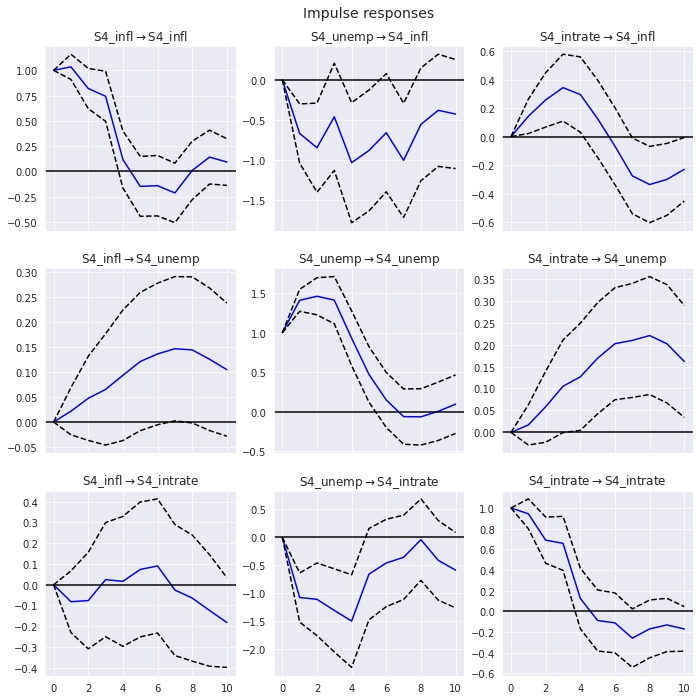

---------------------------------------------
Plotting cumulative effects
---------------------------------------------


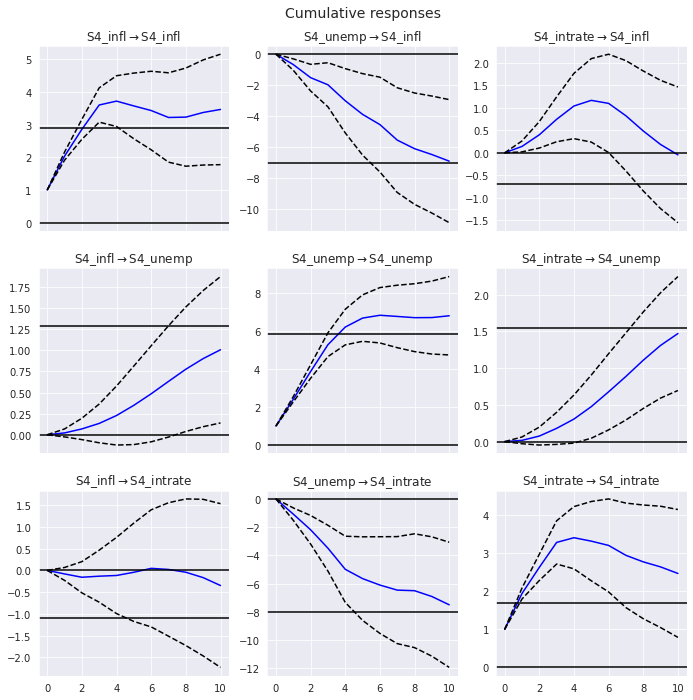

---------------------------------------------
Granger test
---------------------------------------------
Granger causality F-test. H_0: ['S4_unemp', 'S4_intrate'] do not Granger-cause S4_infl. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         5.597          1.846   0.000 (10, 633)
-----------------------------------------------
Granger causality F-test. H_0: ['S4_infl', 'S4_intrate'] do not Granger-cause S4_unemp. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         2.787          1.846   0.002 (10, 633)
-----------------------------------------------
Granger causality F-test. H_0: ['S4_infl', 'S4_unemp'] do not Granger-cause S4_intrate. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
    

In [26]:
var_est(df,5)

# let's choose the best model using BIC

In [27]:
def var_est_BIC(df,i):
    
    print("---------------------------------------------")
    print("VAR result for lag = " + str(i))
    print("---------------------------------------------")
    
    model  = VAR(df)
    result = model.fit(maxlags=i, ic='bic', trend='ctt',verbose=True)
    
    print(result.summary())
    
    print("---------------------------------------------")
    print("Plotting input time series")
    print("---------------------------------------------")
    
    result.plot()
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting time series autocorrelation function")
    print("---------------------------------------------")
          
    result.plot_acorr()
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting IRF")
    print("---------------------------------------------")
    
    irf = result.irf(10)
    irf.plot(orth=False)
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting cumulative effects")
    print("---------------------------------------------")
    
    irf.plot_cum_effects(orth=False)
    plt.show()
    
    print("---------------------------------------------")
    print("Granger test")
    print("---------------------------------------------")
    
    test_result1 = result.test_causality('S4_infl', ['S4_unemp', 'S4_intrate'], kind='f')
    print(test_result1.summary())
    
    test_result2 = result.test_causality('S4_unemp', ['S4_infl', 'S4_intrate'], kind='f')
    print(test_result2.summary())
    
    test_result3 = result.test_causality('S4_intrate', ['S4_infl', 'S4_unemp'], kind='f')
    print(test_result3.summary())
    
    print("---------------------------------------------")
    print("Ljung-Box test for VAR")
    print("---------------------------------------------")
    test_result4 = result.test_whiteness()
    print(test_result4.summary())
    
    

---------------------------------------------
VAR result for lag = 5
---------------------------------------------
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 5, BIC -> 5, FPE -> 5, HQIC -> 5>
Using 5 based on bic criterion
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Nov, 2020
Time:                     02:04:13
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -2.13329
Nobs:                     229.000    HQIC:                  -2.61633
Log likelihood:          -583.839    FPE:                  0.0527595
AIC:                     -2.94299    Det(Omega_mle):       0.0420452
--------------------------------------------------------------------
Results for equation S4_infl
                   coefficient       std. error           t-stat            prob
--------------------------------

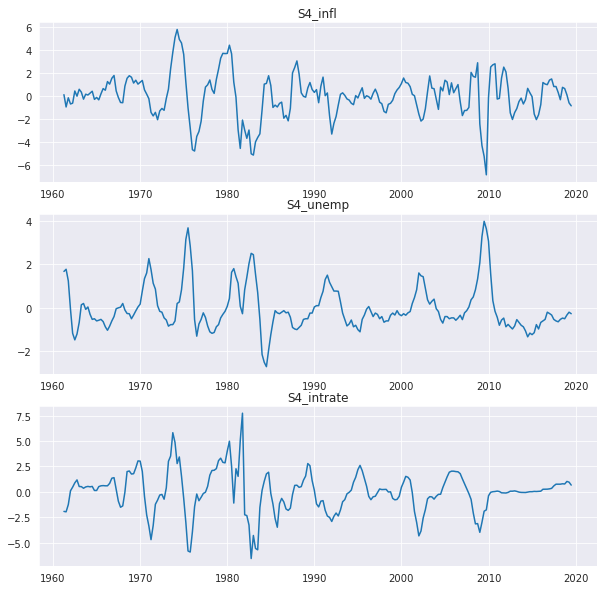

---------------------------------------------
Plotting time series autocorrelation function
---------------------------------------------


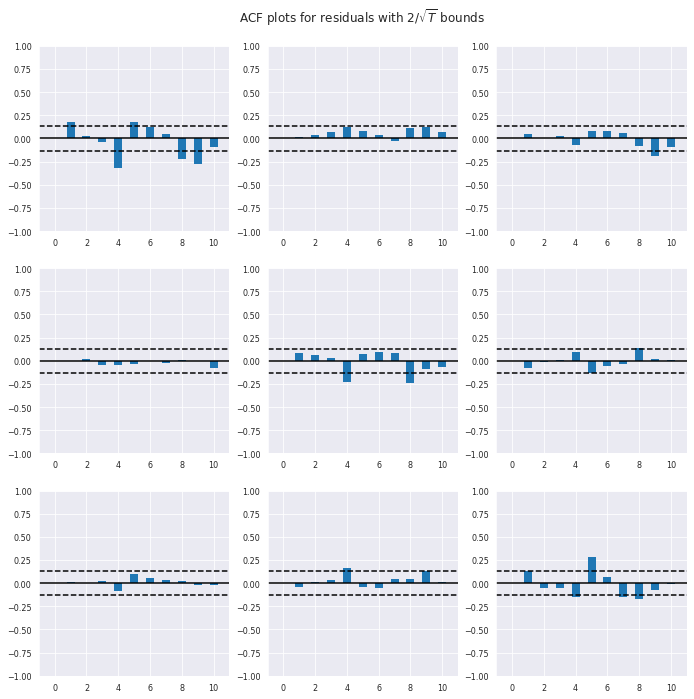

---------------------------------------------
Plotting IRF
---------------------------------------------


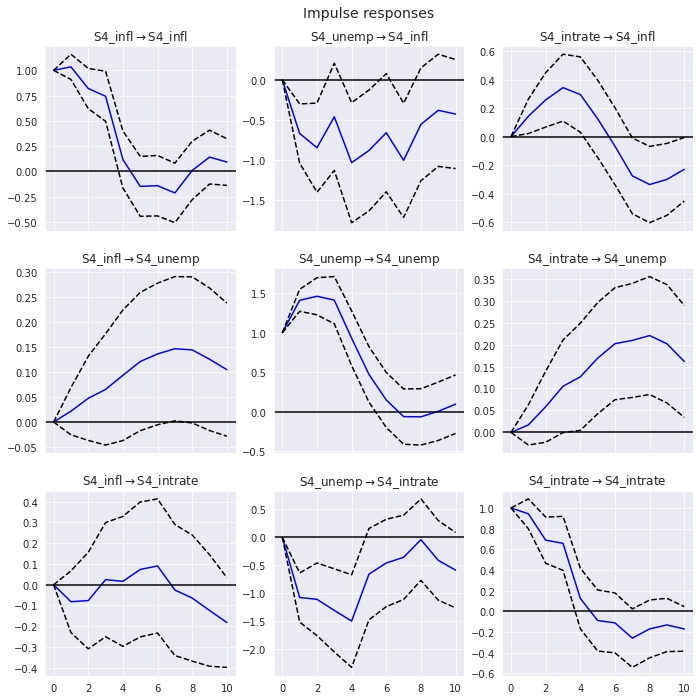

---------------------------------------------
Plotting cumulative effects
---------------------------------------------


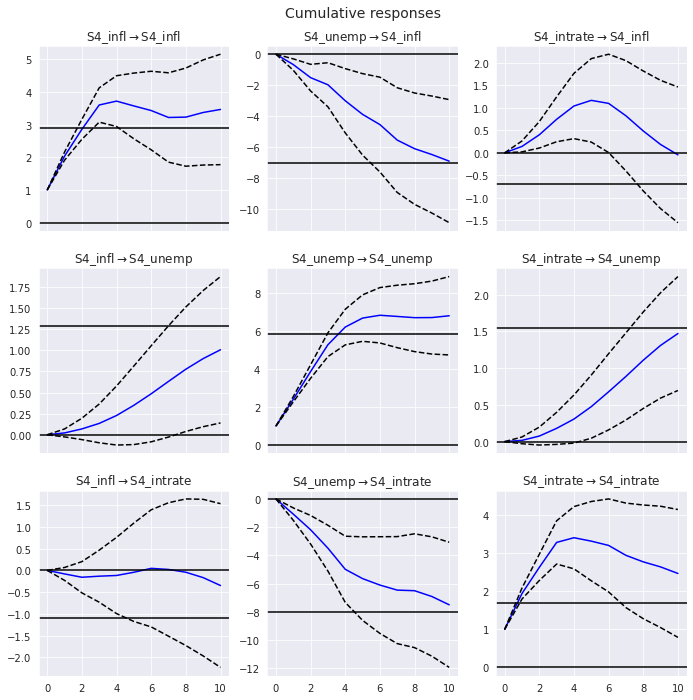

---------------------------------------------
Granger test
---------------------------------------------
Granger causality F-test. H_0: ['S4_unemp', 'S4_intrate'] do not Granger-cause S4_infl. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         5.597          1.846   0.000 (10, 633)
-----------------------------------------------
Granger causality F-test. H_0: ['S4_infl', 'S4_intrate'] do not Granger-cause S4_unemp. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         2.787          1.846   0.002 (10, 633)
-----------------------------------------------
Granger causality F-test. H_0: ['S4_infl', 'S4_unemp'] do not Granger-cause S4_intrate. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
    

In [28]:
var_est_BIC(df,5)